In [221]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()
from datetime import datetime

In [4]:
biased = pd.read_csv('data/biased.csv', encoding='utf8')
biased.date = pd.to_datetime(biased.date)
unbiased = pd.read_csv('data/unbiased.csv', encoding='utf8', parse_dates=True)
unbiased.date = pd.to_datetime(unbiased.date)

In [5]:
split_date = datetime.strptime('1/1/2017', '%d/%m/%Y')

In [6]:
new_biased = biased[biased.date >= split_date]
old_biased = biased[biased.date < split_date]
new_unbiased = unbiased[unbiased.date >= split_date]
old_unbiased = unbiased[unbiased.date < split_date]

In [7]:
counts = new_biased.is_foodborne.value_counts()
print 'Current Is Foodborne Yes: {0} / {1} = {2:2.2f}%'.format(counts.Yes, counts.sum(), 100.*counts.Yes/counts.sum())
counts = old_biased.is_foodborne.value_counts()
print 'Historical Is Foodborne Yes: {0} / {1} = {2:2.2f}%'.format(counts.Yes, counts.sum(), 100.*counts.Yes/counts.sum())

Current Is Foodborne Yes: 949 / 1975 = 48.05%
Historical Is Foodborne Yes: 5899 / 11566 = 51.00%


In [8]:
counts = new_biased.is_multiple.value_counts()
print 'Current Is Multiple Yes: {0} / {1} = {2:2.2f}%'.format(counts.Yes, counts.sum(), 100.*counts.Yes/counts.sum())
counts = old_biased.is_multiple.value_counts()
print 'Historical Is Multiple Yes: {0} / {1} = {2:2.2f}%'.format(counts.Yes, counts.sum(), 100.*counts.Yes/counts.sum())

Current Is Multiple Yes: 277 / 1975 = 14.03%
Historical Is Multiple Yes: 1488 / 11566 = 12.87%


In [75]:
def setup_baseline_data(train_regime='gold', test_regime='gold', random_seed=0, silver_size=10000):
    test_split_date = datetime.strptime('1/1/2017', '%d/%m/%Y')
    biased = pd.read_csv('data/biased.csv', encoding='utf8')
    biased.date = pd.to_datetime(biased.date)
    old_biased = biased[biased['date'] < test_split_date]
    new_biased = biased[biased['date'] >= test_split_date]
    
    unbiased = pd.read_csv('data/unbiased.csv', encoding='utf8')
    unbiased.date = pd.to_datetime(unbiased.date)
    U = len(unbiased) + len(biased)
    
    if train_regime == 'gold':
        old_unbiased = pd.read_excel('data/historical_unbiased.xlsx', encoding='utf8')
        old_unbiased.date = pd.to_datetime(old_unbiased.date)
    elif train_regime == 'silver':
        old_unbiased = unbiased[unbiased.date < test_split_date]
        old_unbiased = old_unbiased.sample(silver_size, random_state=random_seed)
        # assume the biased complement are negative examples
        old_unbiased['is_foodborne'] = 'No'
        old_unbiased['is_multiple'] = 'No'
    else:
        raise ValueError, "Regime must be 'silver' or 'gold'"
        
    if test_regime == 'gold':
        print '[WARNING] THE TEST DATA IS NOT CORRECT FOR THIS REGIME YET'
        old_unbiased = pd.read_excel('data/historical_unbiased.xlsx', encoding='utf8')
        old_unbiased.date = pd.to_datetime(old_unbiased.date)
        # for now we are passing dummy test data
        new_unbiased = pd.DataFrame(old_unbiased)
    elif test_regime == 'silver':
        unbiased = pd.read_csv('data/unbiased.csv', encoding='utf8')
        unbiased.date = pd.to_datetime(unbiased.date)
        new_unbiased = unbiased[unbiased.date >= test_split_date]
        new_unbiased = new_unbiased.sample(silver_size, random_state=random_seed)
        # assume the biased complement are negative examples
        new_unbiased['is_foodborne'] = 'No'
        new_unbiased['is_multiple'] = 'No'
    else:
        raise ValueError, "Regime must be 'silver' or 'gold'"
    
    old_biased['is_foodborne'] = old_biased['is_foodborne'].map({'Yes':1, 'No':0})
    old_unbiased['is_foodborne'] = old_unbiased['is_foodborne'].map({'Yes':1, 'No':0})
    new_biased['is_foodborne'] = new_biased['is_foodborne'].map({'Yes':1, 'No':0})
    new_unbiased['is_foodborne'] = new_unbiased['is_foodborne'].map({'Yes':1, 'No':0})
    
    old_biased['is_multiple'] = old_biased['is_multiple'].map({'Yes':1, 'No':0})
    old_unbiased['is_multiple'] = old_unbiased['is_multiple'].map({'Yes':1, 'No':0})
    new_biased['is_multiple'] = new_biased['is_multiple'].map({'Yes':1, 'No':0})
    new_unbiased['is_multiple'] = new_unbiased['is_multiple'].map({'Yes':1, 'No':0})
    
    return {
        'train_data': {
            'text':old_biased['text'].tolist() + old_unbiased['text'].tolist(),
            'is_foodborne':old_biased['is_foodborne'].tolist() + old_unbiased['is_foodborne'].tolist(),
            'is_multiple':old_biased['is_multiple'].tolist() + old_unbiased['is_multiple'].tolist(),
            'is_biased':[True]*len(old_biased) + [False]*len(old_unbiased)
        },
        'test_data': {
            'text':new_biased['text'].tolist() + new_unbiased['text'].tolist(),
            'is_foodborne':new_biased['is_foodborne'].tolist() + new_unbiased['is_foodborne'].tolist(),
            'is_multiple':new_biased['is_multiple'].tolist() + new_unbiased['is_multiple'].tolist(),
            'is_biased':[True]*len(new_biased) + [False]*len(new_unbiased)
        },
        'U':U
    }

In [174]:
random_seed = 0

In [76]:
data = setup_baseline_data(train_regime='silver', test_regime='silver', random_seed=random_seed)

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [77]:
train_data = data['train_data']
test_data = data['test_data']
U = data['U']

In [78]:
print "Is Foodborne stats"
print 'train data: {0} yes, {1} no => {2:2.2f}% yes'.format(
    sum(train_data['is_foodborne']), len(train_data['is_foodborne'])-sum(train_data['is_foodborne']), 
    100.*sum(train_data['is_foodborne'])/len(train_data['is_foodborne']))
print 'test data: {0} yes, {1} no => {2:2.2f}% yes'.format(
    sum(test_data['is_foodborne']), len(test_data['is_foodborne'])-sum(test_data['is_foodborne']), 
    100.*sum(test_data['is_foodborne'])/len(test_data['is_foodborne']))

print "Is Multiple stats"
print 'train data: {0} yes, {1} no => {2:2.2f}% yes'.format(
    sum(train_data['is_multiple']), len(train_data['is_multiple'])-sum(train_data['is_multiple']), 
    100.*sum(train_data['is_multiple'])/len(train_data['is_multiple']))
print 'test data: {0} yes, {1} no => {2:2.2f}% yes'.format(
    sum(test_data['is_multiple']), len(test_data['is_multiple'])-sum(test_data['is_multiple']), 
    100.*sum(test_data['is_multiple'])/len(test_data['is_multiple']))

print "Bias stats"
print '{} train data: {} biased, {} biased complement'.format(
    len(train_data['text']), sum(train_data['is_biased']), len(train_data['text'])-sum(train_data['is_biased']))
print '{} test data: {} biased, {} biased complement'.format(
    len(test_data['text']), sum(test_data['is_biased']), len(test_data['text'])-sum(test_data['is_biased']))

Is Foodborne stats
train data: 5899 yes, 15667 no => 27.35% yes
test data: 949 yes, 11026 no => 7.92% yes
Is Multiple stats
train data: 1488 yes, 20078 no => 6.90% yes
test data: 277 yes, 11698 no => 2.31% yes
Bias stats
21566 train data: 11566 biased, 10000 biased complement
11975 test data: 1975 biased, 10000 biased complement


In [179]:
def calc_train_importance_weights(is_biased, U):
    B = float(sum(is_biased))
    Bc = len(is_biased) - B
#     print 'U:{}, B:{}, Bc:{}'.format(U,B, Bc)
    w_B = 1./U
    w_Bc = (1.-(B/U))*(1./Bc)
    iw = np.array([w_B if label else w_Bc for label in is_biased])
    rescaled = (len(is_biased)/iw.sum())*iw
#     print 'w_B:{}, w_Bc:{}'.format(*sorted(np.unique(rescaled).tolist()))
    return rescaled

def importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, threshold=.5):
    # find the precision at this threshold
    in_Up = y_pred_probs >= threshold # same as predictions at this threshold
    Up = in_Up.sum().astype(np.float32) + 1e-15 # for stability when there are no positive predictions
    biased_and_Up = is_biased & in_Up
    unbiased_and_Up = (~is_biased) & in_Up
    bias_rate = sum(biased_and_Up)/Up
    bias_term = bias_rate * (1./Up) * ((y_trues == 1) & biased_and_Up).sum()
    unbias_term = (1. - bias_rate) * (1./Up) * ((y_trues == 1) & unbiased_and_Up).sum()
    precision = bias_term + unbias_term

    # find recall at this threshold
    in_Ur = y_trues == 1 # same as true positives
    Ur = in_Ur.sum().astype(np.float32) + 1e-15 # for stability when there are no positive examples
    biased_and_Ur = is_biased & in_Ur
    unbiased_and_Ur = (~is_biased) & in_Ur
    bias_rate = sum(biased_and_Ur)/Ur
    bias_term = bias_rate * (1./Ur) * (in_Up & biased_and_Ur).sum() # in_Up is same as preds
    unbias_term = (1. - bias_rate) * (1./Ur) * (in_Up & unbiased_and_Ur).sum()
    recall = bias_term + unbias_term
    
    return precision, recall

def importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased):
    thresholds = np.linspace(1, 0, 100)
    precisions, recalls = [], []
    for t in thresholds:
        p, r = importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, t)
        precisions.append(p)
        recalls.append(r)
        if r >= 1.:
            break
    return np.array(precisions), np.array(recalls), thresholds[:len(precisions)]

def area_under_pr_curve(precisions, recalls):
    # calculate area under curve using trapezoidal integration
    aupr = 0.
    for i in range(len(precisions)-1):
        aupr += .5 * (recalls[i+1] - recalls[i]) * (precisions[i] + precisions[i+1])
    return aupr

In [247]:
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib

# model components
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np

In [206]:
def score_model(model, xs, ys, bs, U, fit_weight_kwd, n_cv_splits, random_seed):
    folds = StratifiedKFold(n_splits=n_cv_splits, random_state=random_seed)
    stratify_on_these = ['{},{}'.format(y,b) for y,b in zip(ys, bs)]
    dev_scores = []
    for train_idx, dev_idx in folds.split(np.zeros(len(xs)), stratify_on_these):

        train_text = np.array(xs)[train_idx]
        train_ys = np.array(ys)[train_idx]
        train_is_biased = np.array(bs)[train_idx]

        dev_text = np.array(xs)[dev_idx]
        dev_ys = np.array(ys)[dev_idx]
        dev_is_biased = np.array(bs)[dev_idx]
        
        train_importance_weights = calc_train_importance_weights(train_is_biased, U)
        model.fit(train_text, train_ys, **{fit_weight_kwd:train_importance_weights})
        scored_devs = model.predict_proba(dev_text)[:,1]
        dev_precisions, dev_recalls, _ = importance_weighted_pr_curve(dev_ys, scored_devs, dev_is_biased)
        dev_aupr = area_under_pr_curve(dev_precisions, dev_recalls)
#         print 'AUPR: {0:2.2f}'.format(dev_aupr)
        dev_scores.append(dev_aupr)
    return np.array(dev_scores)

In [254]:
def random_search(model, random_hyperparams, model_fname, **score_kwds):
    experiments = []
    N = len(random_hyperparams.values()[0])
    best_score = -1.0
    best_params = {}
    for i in range(N):
        random_hyperparam = {k:v[i] for k,v in random_hyperparams.items()}
        model.set_params(**random_hyperparam)
        print 'Experiment {}/{} -------'.format(i+1, N)
        print 'params: {}'.format(random_hyperparam)
        experiment = {'i':i,
                      'params':model.get_params(),
                      'scores':score_model(model, **score_kwds)}
        experiments.append(experiment)
        print 'scores: {}'.format(experiments[-1]['scores'])
        score = experiments[-1]['scores'].mean()
        if score > best_score:
            print 'New best: {0:2.2f}'.format(score)
            best_score = score
            joblib.dump(model, model_fname)
    return experiments

In [255]:
# best logistic regression for sick
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=.95, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
logreg = LogisticRegression(
    fit_intercept=True, 
    C=100, 
    penalty='l2',
    verbose=0
)
sick_logreg = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('logreg',logreg)
    ])

In [256]:
N = 2
random_hyperparams = {
    'count__ngram_range':[(1,n) for n in npr.randint(1,4, N)],
    'count__max_df':npr.uniform(.9, 1.0, N),
    'tfidf__norm':npr.choice(['l1', 'l2', None], N),
    'tfidf__use_idf':npr.choice([True, False], N),
    'logreg__C':npr.randint(0,200, N),
    'logreg__penalty':npr.choice(['l1', 'l2'], N)
}

score_kwds = {
    'xs':train_data['text'],
    'ys':train_data['is_foodborne'],
    'bs':train_data['is_biased'],
    'U':U,
    'fit_weight_kwd':'logreg__sample_weight',
    'n_cv_splits':3,
    'random_seed':random_seed
}
experiments = random_search(sick_logreg, random_hyperparams, 'best_logreg.pkl', **score_kwds)
joblib.dump(experiments, 'logreg_hyperparam_experiments.pkl')

Experiment 1/2 -------
params: {'count__max_df': 0.9447775573777164, 'count__ngram_range': (1, 1), 'logreg__penalty': 'l2', 'tfidf__use_idf': True, 'tfidf__norm': None, 'logreg__C': 8}
scores: [ 0.80601555  0.77363539  0.81816675]
New best: 0.80
Experiment 2/2 -------
params: {'count__max_df': 0.98916077939641511, 'count__ngram_range': (1, 2), 'logreg__penalty': 'l1', 'tfidf__use_idf': True, 'tfidf__norm': None, 'logreg__C': 63}
scores: [ 0.83692897  0.79933422  0.8452863 ]
New best: 0.83


['logreg_hyperparam_experiments.pkl']

In [ ]:
best = sorted(experiments, key=lambda x:x['scores'].mean(), reverse=True)[0]
print best['i'], best['params'], best['scores']

In [262]:
ls

Baseline Experiments.ipynb         best_logreg.pkl
Data Wrangling.ipynb               data/
Evaluation.ipynb                   logreg_hyperparam_experiments.pkl
IFS.ipynb


In [274]:
%%writefile baseline_experiment_util.py
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib

def setup_baseline_data(train_regime='gold', test_regime='gold', random_seed=0, silver_size=10000):
    test_split_date = datetime.strptime('1/1/2017', '%d/%m/%Y')
    biased = pd.read_csv('data/biased.csv', encoding='utf8')
    biased.date = pd.to_datetime(biased.date)
    old_biased = biased[biased['date'] < test_split_date]
    new_biased = biased[biased['date'] >= test_split_date]
    
    unbiased = pd.read_csv('data/unbiased.csv', encoding='utf8')
    unbiased.date = pd.to_datetime(unbiased.date)
    U = len(unbiased) + len(biased)
    
    if train_regime == 'gold':
        old_unbiased = pd.read_excel('data/historical_unbiased.xlsx', encoding='utf8')
        old_unbiased.date = pd.to_datetime(old_unbiased.date)
    elif train_regime == 'silver':
        old_unbiased = unbiased[unbiased.date < test_split_date]
        old_unbiased = old_unbiased.sample(silver_size, random_state=random_seed)
        # assume the biased complement are negative examples
        old_unbiased['is_foodborne'] = 'No'
        old_unbiased['is_multiple'] = 'No'
    else:
        raise ValueError, "Regime must be 'silver' or 'gold'"
        
    if test_regime == 'gold':
        print '[WARNING] THE TEST DATA IS NOT CORRECT FOR THIS REGIME YET'
        old_unbiased = pd.read_excel('data/historical_unbiased.xlsx', encoding='utf8')
        old_unbiased.date = pd.to_datetime(old_unbiased.date)
        # for now we are passing dummy test data
        new_unbiased = pd.DataFrame(old_unbiased)
    elif test_regime == 'silver':
        unbiased = pd.read_csv('data/unbiased.csv', encoding='utf8')
        unbiased.date = pd.to_datetime(unbiased.date)
        new_unbiased = unbiased[unbiased.date >= test_split_date]
        new_unbiased = new_unbiased.sample(silver_size, random_state=random_seed)
        # assume the biased complement are negative examples
        new_unbiased['is_foodborne'] = 'No'
        new_unbiased['is_multiple'] = 'No'
    else:
        raise ValueError, "Regime must be 'silver' or 'gold'"
    
    old_biased['is_foodborne'] = old_biased['is_foodborne'].map({'Yes':1, 'No':0})
    old_unbiased['is_foodborne'] = old_unbiased['is_foodborne'].map({'Yes':1, 'No':0})
    new_biased['is_foodborne'] = new_biased['is_foodborne'].map({'Yes':1, 'No':0})
    new_unbiased['is_foodborne'] = new_unbiased['is_foodborne'].map({'Yes':1, 'No':0})
    
    old_biased['is_multiple'] = old_biased['is_multiple'].map({'Yes':1, 'No':0})
    old_unbiased['is_multiple'] = old_unbiased['is_multiple'].map({'Yes':1, 'No':0})
    new_biased['is_multiple'] = new_biased['is_multiple'].map({'Yes':1, 'No':0})
    new_unbiased['is_multiple'] = new_unbiased['is_multiple'].map({'Yes':1, 'No':0})
    
    return {
        'train_data': {
            'text':old_biased['text'].tolist() + old_unbiased['text'].tolist(),
            'is_foodborne':old_biased['is_foodborne'].tolist() + old_unbiased['is_foodborne'].tolist(),
            'is_multiple':old_biased['is_multiple'].tolist() + old_unbiased['is_multiple'].tolist(),
            'is_biased':[True]*len(old_biased) + [False]*len(old_unbiased)
        },
        'test_data': {
            'text':new_biased['text'].tolist() + new_unbiased['text'].tolist(),
            'is_foodborne':new_biased['is_foodborne'].tolist() + new_unbiased['is_foodborne'].tolist(),
            'is_multiple':new_biased['is_multiple'].tolist() + new_unbiased['is_multiple'].tolist(),
            'is_biased':[True]*len(new_biased) + [False]*len(new_unbiased)
        },
        'U':U
    }

def calc_train_importance_weights(is_biased, U):
    B = float(sum(is_biased))
    Bc = len(is_biased) - B
#     print 'U:{}, B:{}, Bc:{}'.format(U,B, Bc)
    w_B = 1./U
    w_Bc = (1.-(B/U))*(1./Bc)
    iw = np.array([w_B if label else w_Bc for label in is_biased])
    rescaled = (len(is_biased)/iw.sum())*iw
#     print 'w_B:{}, w_Bc:{}'.format(*sorted(np.unique(rescaled).tolist()))
    return rescaled

def importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, threshold=.5):
    # find the precision at this threshold
    in_Up = y_pred_probs >= threshold # same as predictions at this threshold
    Up = in_Up.sum().astype(np.float32) + 1e-15 # for stability when there are no positive predictions
    biased_and_Up = is_biased & in_Up
    unbiased_and_Up = (~is_biased) & in_Up
    bias_rate = sum(biased_and_Up)/Up
    bias_term = bias_rate * (1./Up) * ((y_trues == 1) & biased_and_Up).sum()
    unbias_term = (1. - bias_rate) * (1./Up) * ((y_trues == 1) & unbiased_and_Up).sum()
    precision = bias_term + unbias_term

    # find recall at this threshold
    in_Ur = y_trues == 1 # same as true positives
    Ur = in_Ur.sum().astype(np.float32) + 1e-15 # for stability when there are no positive examples
    biased_and_Ur = is_biased & in_Ur
    unbiased_and_Ur = (~is_biased) & in_Ur
    bias_rate = sum(biased_and_Ur)/Ur
    bias_term = bias_rate * (1./Ur) * (in_Up & biased_and_Ur).sum() # in_Up is same as preds
    unbias_term = (1. - bias_rate) * (1./Ur) * (in_Up & unbiased_and_Ur).sum()
    recall = bias_term + unbias_term
    
    return precision, recall

def importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased):
    thresholds = np.linspace(1, 0, 100)
    precisions, recalls = [], []
    for t in thresholds:
        p, r = importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, t)
        precisions.append(p)
        recalls.append(r)
        if r >= 1.:
            break
    return np.array(precisions), np.array(recalls), thresholds[:len(precisions)]

def area_under_pr_curve(precisions, recalls):
    # calculate area under curve using trapezoidal integration
    aupr = 0.
    for i in range(len(precisions)-1):
        aupr += .5 * (recalls[i+1] - recalls[i]) * (precisions[i] + precisions[i+1])
    return aupr

def score_model(model, xs, ys, bs, U, fit_weight_kwd, n_cv_splits, random_seed):
    folds = StratifiedKFold(n_splits=n_cv_splits, random_state=random_seed)
    stratify_on_these = ['{},{}'.format(y,b) for y,b in zip(ys, bs)]
    dev_scores = []
    for train_idx, dev_idx in folds.split(np.zeros(len(xs)), stratify_on_these):

        train_text = np.array(xs)[train_idx]
        train_ys = np.array(ys)[train_idx]
        train_is_biased = np.array(bs)[train_idx]

        dev_text = np.array(xs)[dev_idx]
        dev_ys = np.array(ys)[dev_idx]
        dev_is_biased = np.array(bs)[dev_idx]
        
        train_importance_weights = calc_train_importance_weights(train_is_biased, U)
        model.fit(train_text, train_ys, **{fit_weight_kwd:train_importance_weights})
        scored_devs = model.predict_proba(dev_text)[:,1]
        dev_precisions, dev_recalls, _ = importance_weighted_pr_curve(dev_ys, scored_devs, dev_is_biased)
        dev_aupr = area_under_pr_curve(dev_precisions, dev_recalls)
#         print 'AUPR: {0:2.2f}'.format(dev_aupr)
        dev_scores.append(dev_aupr)
    return np.array(dev_scores)

def random_search(model, random_hyperparams, model_fname, **score_kwds):
    experiments = []
    N = len(random_hyperparams.values()[0])
    best_score = -1.0
    best_params = {}
    for i in range(N):
        random_hyperparam = {k:v[i] for k,v in random_hyperparams.items()}
        model.set_params(**random_hyperparam)
        print '\n------- Experiment {}/{} -------'.format(i+1, N)
        print 'params: {}'.format(random_hyperparam)
        experiment = {'i':i,
                      'params':model.get_params(),
                      'scores':score_model(model, **score_kwds)}
        experiments.append(experiment)
        print 'scores: {}'.format(experiments[-1]['scores'])
        score = experiments[-1]['scores'].mean()
        if score > best_score:
            print 'New best: {0:2.2f}'.format(score)
            best_score = score
            joblib.dump(model, model_fname)
    return experiments

Overwriting baseline_experiment_util.py


In [271]:
%%writefile logreg_model.py
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

#logistic regression pipeline def
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=.95, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        )
tfidf = TfidfTransformer(norm='l2', use_idf=True)
logreg = LogisticRegression(
    fit_intercept=True, 
    C=100, 
    penalty='l2',
    verbose=0
)
model = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('logreg',logreg)
    ])

Overwriting logreg_model.py


In [275]:
%%writefile logreg_sick_dev.py
import numpy.random as npr

from sklearn.externals import joblib

from baseline_experiment_util import setup_baseline_data, random_search
from logreg_model import model

random_seed = 0

data = setup_baseline_data(train_regime='silver', test_regime='silver', random_seed=random_seed)
train_data = data['train_data']
U = data['U']

N = 2
random_hyperparams = {
    'count__ngram_range':[(1,n) for n in npr.randint(1,4, N)],
    'count__max_df':npr.uniform(.9, 1.0, N),
    'tfidf__norm':npr.choice(['l1', 'l2', None], N),
    'tfidf__use_idf':npr.choice([True, False], N),
    'logreg__C':npr.choice(n,
    'logreg__penalty':npr.choice(['l1', 'l2'], N)
}

score_kwds = {
    'xs':train_data['text'],
    'ys':train_data['is_foodborne'],
    'bs':train_data['is_biased'],
    'U':U,
    'fit_weight_kwd':'logreg__sample_weight',
    'n_cv_splits':3,
    'random_seed':random_seed
}
experiments = random_search(model, random_hyperparams, 'best_logreg.pkl', **score_kwds)
print 'Writing out experiments'
joblib.dump(experiments, 'logreg_hyperparam_experiments.pkl')
print 'All done'

Overwriting logreg_sick_dev.py


In [273]:
!python logreg_sick_dev.py

/Users/thomaseffland/Development/projects/fbnyc/FoodborneNYC/jamia_2017/revision/baseline_experiment_util.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  old_biased['is_foodborne'] = old_biased['is_foodborne'].map({'Yes':1, 'No':0})
/Users/thomaseffland/Development/projects/fbnyc/FoodborneNYC/jamia_2017/revision/baseline_experiment_util.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_biased['is_foodborne'] = new_biased['is_foodborne'].map({'Yes':1, 'No':0})
/Users/thomaseffland/Development/projects/fbnyc/FoodborneNYC/jamia_201

In [276]:
ls

Baseline Experiments.ipynb         best_logreg.pkl
Data Wrangling.ipynb               data/
Evaluation.ipynb                   logreg_hyperparam_experiments.pkl
IFS.ipynb                          logreg_model.py
baseline_experiment_util.py        logreg_model.pyc
baseline_experiment_util.pyc       logreg_sick_dev.py


In [278]:
from time import time

In [279]:
time()

1498493528.299747

[TODO](find the link for this)

p_y:0.00665973154362
1343.0


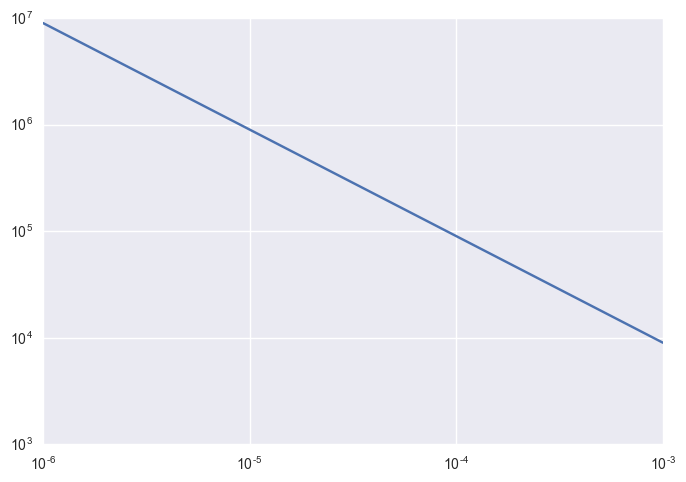

In [309]:
# sample size needed to reasonably approximate binomial based on 3-sigma normal approximation
n_lower = lambda p:np.ceil(9.*p/(1-p))
n_upper = lambda p:np.ceil(9.*(1-p)/p)
p_y = .53*(13000./1117500) + .0005*(1-13000./1117500)
print 'p_y:{}'.format(p_y)

p = 1./1000
pspace = np.logspace(-6,-3,100)
n_lower(p), n_upper(p)
# plt.plot(pspace, [n_lower(p) for p in pspace])
plt.plot(pspace, [n_upper(p) for p in pspace])
print(n_upper(p_y))
# plt.xlim(0.,.01)
plt.xscale('log')
plt.yscale('log')

0.999247963211
1995


/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


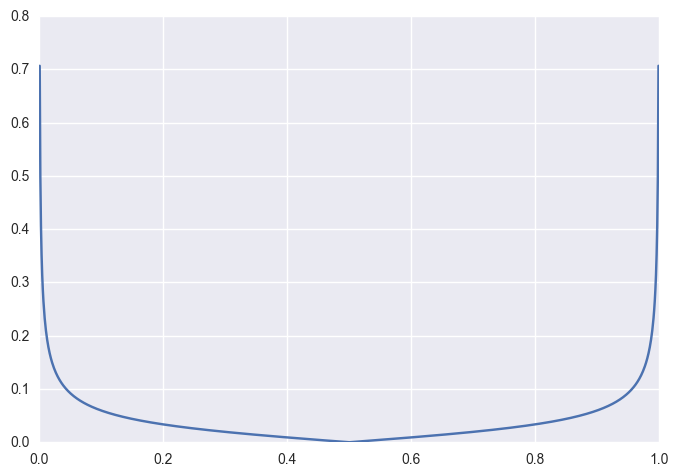

In [287]:
n, p = 1995, 1/1000.
skewness = lambda n,p:float(abs(1-2*p))/np.sqrt(n*p*(1.-p))
print skewness(n,p)

plt.plot(np.linspace(0,1.,1000), [skewness(,a) for a in np.linspace(0,1.,1000)])
print n